In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the 'Value' type
from utils import Value, MLP
from utils import PalindromeDataset, PalindromeDatasetFull

In [3]:
# Example computation
a = Value(1)
b = Value(2)
c = Value(3)
d = Value(4)

e = a*b + c*d
f = e/2.

# checking final values and initial grads (should be zero)
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

# backprop
f.backward()

# checking final grads
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

Value(data=14) Value(data=7.0) 0 0 0 0 0 0
Value(data=14) Value(data=7.0) 1.0 0.5 2.0 1.5 0.5 1


In [4]:
# showing the training of a simple NN, with some data
# input dim=3, output dim=1, atchitecture : NN with 4 layers : 3,4,4,1 neurons resp
from utils import MLP

# testing the MLP 
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1] # labels
losslog = []
a = MLP(3, [4,4,1])
for step in range(200) : # 200 epochs
    # forward pass
    ypred = [a(x)[0] for x in xs]
    loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

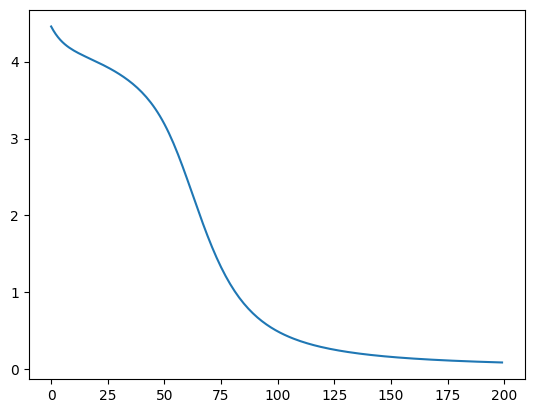

In [5]:
plt.plot(losslog)
plt.show()

In [6]:
# checking performance on the four data points
# should be close to ys=[1,-1,-1,1]
[a(x)[0] for x in xs]

[Value(data=0.8442281397216626),
 Value(data=-0.8781425781240726),
 Value(data=-0.8376995370875562),
 Value(data=0.8563240746183143)]

In [7]:
datasetMaker = PalindromeDataset(10)
dataset = datasetMaker.generate_dataset(4, 6)

In [8]:
dataset

[('1010110101', 1),
 ('1100010111', 0),
 ('0110110110', 1),
 ('1000111011', 0),
 ('0001111000', 1),
 ('1010111011', 0),
 ('1000011000', 0),
 ('0111101011', 0),
 ('0011100000', 0),
 ('1110000111', 1)]

In [7]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

In [10]:
xs, ys = convert_to_form(dataset)

In [11]:
ys

[1, 0, 1, 0, 1, 0, 0, 0, 0, 1]

In [12]:
# showing the training of a simple NN, with some data
# input dim=10, output dim=1, atchitecture : NN with 1 hidden layers : 4 with neurons
from utils import MLP

losslog = []
a = MLP(10, [4, 1])
for step in range(500) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

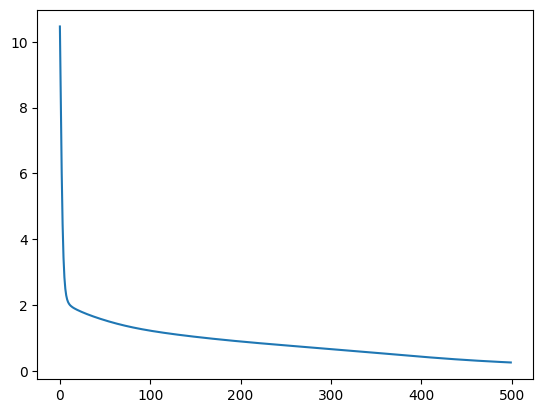

In [13]:
plt.plot(losslog)
plt.show()

In [14]:
predictions = [a(k) for k in xs]
actual_predictions = ys

In [15]:
predictions

[[Value(data=0.8884705600612981)],
 [Value(data=0.23235907424888713)],
 [Value(data=0.8764593584452574)],
 [Value(data=0.005357261311221476)],
 [Value(data=0.7965402720794859)],
 [Value(data=0.07742876194684467)],
 [Value(data=-0.045671102022587104)],
 [Value(data=-0.020916447097058057)],
 [Value(data=0.05262121246285286)],
 [Value(data=0.6588579521961914)]]

In [16]:
actual_predictions

[1, 0, 1, 0, 1, 0, 0, 0, 0, 1]

Training on Full Dataset

In [3]:
datasetMaker = PalindromeDatasetFull(10)
dataset = datasetMaker.generate_dataset()

In [4]:
len(dataset)

1024

In [5]:
dataset[:5]

[('0000000000', 1),
 ('0000000001', 0),
 ('0000000010', 0),
 ('0000000011', 0),
 ('0000000100', 0)]

In [9]:
losslog

[1234.7414055671202, 1180.6119097780274, 1129.589673418031, 1081.5214399845022]

In [12]:
from tqdm.notebook import tqdm
import random

random.shuffle(dataset)
xs, ys = convert_to_form(dataset)

losslog = []
a = MLP(10, [4, 1])
weight = 32. # added weight to try and counter the class imbalance
nepochs = 250

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    if step%25==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        w.data -= 0.001 * w.grad # standard SGD for now

plt.plot(losslog)
plt.show()

  0%|          | 0/250 [00:00<?, ?it/s]

epoch 0 loss 1438.2206
epoch 25 loss 1506.3868
epoch 50 loss 1504.1485
epoch 75 loss 1509.5961
epoch 100 loss 1488.8349
epoch 125 loss 1494.9097
epoch 150 loss 1489.3618
epoch 175 loss 1480.1997


KeyboardInterrupt: 

In [13]:
predictions = np.array([a(k)[0].data for k in xs])
max(predictions), min(predictions)

(0.782495207954584, 0.5301267377791955)

In [24]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 0.0312 f1 0.0606
Threshold 0.2 accuracy 0.0312 f1 0.0606
Threshold 0.3 accuracy 0.0312 f1 0.0606
Threshold 0.4 accuracy 0.0312 f1 0.0606
Threshold 0.5 accuracy 0.0312 f1 0.0606
Threshold 0.6 accuracy 0.1328 f1 0.0672
Threshold 0.7 accuracy 0.8174 f1 0.0878
Threshold 0.8 accuracy 0.9688 f1 0.0000
Threshold 0.9 accuracy 0.9688 f1 0.0000


In [11]:
from sklearn.metrics import confusion_matrix

pred_thresh = 0.4
preds = 1*(predictions > pred_thresh)
confusion_matrix(ys, preds)

array([[607, 385],
       [ 17,  15]], dtype=int64)

In [25]:
max(predictions), min(predictions)

(0.15806089646083163, -0.2591908585429663)